# Traffy Fondue Problem Report Classification

## Setup

In [1]:
# !pip install pandas torch torchtext torchmetrics pythainlp pytorch_lightning wandb scikit-learn matplotlib

In [2]:
%env WANDB_NOTEBOOK_NAME="traffy_fondue_classification.ipynb"

env: WANDB_NOTEBOOK_NAME="traffy_fondue_classification.ipynb"


In [3]:
# Logger
import wandb
wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "traffy_fondue_classification.ipynb".
wandb: Currently logged in as: noppakorn (meen). Use `wandb login --relogin` to force relogin


True

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import sklearn.model_selection
import torchmetrics

from pythainlp.tokenize import word_tokenize

import torch
from torch import optim, nn
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import WandbLogger

seed = 42  # The answer to everything
seed_everything(seed, workers=True)

Global seed set to 42


42

## Dataset

In [5]:
df = pd.read_csv("./traffy-data-2023.csv")
df = df.loc[:, ["type", "comment"]]

df = df.rename({"comment": "text", "type": "tag"}, axis=1)

# Data cleansing

# Clean the tag
def clean_tag(tag: str) -> str:
    tag = tag[1:-1]
    tag = tag.split(",")

    if len(tag) == 0:
        return "Unknown"

    if tag[0] == "ร้องเรียน" and len(tag) > 1:
        return tag[1]
    return tag[0]

df.loc[:, "tag"] = df.loc[:, "tag"].apply(clean_tag)
df = df[~(df.loc[:, "tag"].isin({"Unknown", "", "ร้องเรียน"}))]

# Use only tag with >= 1000 reports
tags = df.loc[:, "tag"].value_counts()
tags = tags[(tags.values >= 1000)]
df = df[df.loc[:, "tag"].isin(tags.keys())]

def clean_text(text):
    return word_tokenize(text, engine="newmm")

df.loc[:, "text"] = df.loc[:, "text"].apply(clean_text)

df = df.reset_index(drop=True)

df

,tag,text
0,ถนน,"[มี, น้ำซึม, ออกมา, บริเวณ, ถนน, , ทำให้, มี,..."
1,ท่อระบายน้ำ,"[ท่อน้ำ, แตก, , น้ำ, ผุด, ไหล, ตลอด]"
2,ท่อระบายน้ำ,"[ฝ่า, ท่อ, ชำรุด]"
3,ท่อระบายน้ำ,"[ฝา, ท่อ, ชำรุด]"
4,จราจร,"[ตำรวจ, ไม่, จับ, มอ, ไซ, ย้อนศร, , วิน, มอ, ..."
...,...,...
67177,ความสะอาด,"[ช่วย, เก็บ, ขยะ, หน่อย, ครับ]"
67178,ถนน,"[ศูนย์, เรื่องราว, ร้องทุกข์, , ได้รับ, การ, ..."
67179,ทางเท้า,"[มี, การ, ขาย, น้ำ, กระท่อม, , และ, กัญชา, เป..."
67180,ถนน,"[ปัญหา, , :, , :, , ประชาชน, ต้องการ, ให้, ..."


In [6]:
print("Tags Statistics")
print(df.tag.value_counts())


print("---")
print("Text Statistics")
print("Max words per sentence", df.text.apply(len).max())
print("Average words per sentence", df.text.apply(len).mean())

Tags Statistics
tag
ถนน            24471
ทางเท้า         7750
ความสะอาด       5983
แสงสว่าง        5108
กีดขวาง         4269
ความปลอดภัย     3404
ป้าย            2863
เสียงรบกวน      2705
ท่อระบายน้ำ     2547
จราจร           2073
ต้นไม้          1933
สะพาน           1823
สัตว์จรจัด      1201
สายไฟ           1052
Name: count, dtype: int64
---
Text Statistics
Max words per sentence 2492
Average words per sentence 57.73838230478402


In [7]:
def yield_tokens(sentences_tokenized):
    for word in sentences_tokenized:
        yield word


vocab = build_vocab_from_iterator(yield_tokens(df.text.tolist()), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

In [8]:
tag_to_idx = {j:i for i, j in enumerate(tags.keys())}
idx_to_tag = {j:i for i, j in tag_to_idx.items()}

In [9]:
class TraffyDataset(Dataset):
    def __init__(self, sentences_tokenized, tag, vocab, tag_to_idx, pad_length=256):
        self.sentences_tokenized = sentences_tokenized
        self.tag = tag
        self.vocab = vocab
        self.tag_to_idx = tag_to_idx

        self.pad_length = pad_length
        self.padding_index = self.vocab["<pad>"]

    def __len__(self):
        return len(self.sentences_tokenized)

    def __getitem__(self, idx):
        tokens = self.vocab(self.sentences_tokenized[idx])
        sentence_encoded = torch.LongTensor(tokens[:self.pad_length])

        pad = nn.ConstantPad1d(
            (0, self.pad_length - len(sentence_encoded)), self.padding_index)
        sentence_encoded = pad(sentence_encoded)

        tag_encoded = torch.tensor(tag_to_idx[self.tag[idx]])
        return sentence_encoded, tag_encoded

In [10]:
class TraffyModel(pl.LightningModule):
    def __init__(self, vocab_len, class_count, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            vocab_len, self.config["embedding_dim"])

        # self.dropout = nn.Dropout(p=self.config["dropout_rate"])
        self.lstm = nn.LSTM(
            self.config["embedding_dim"], self.config["lstm_hidden_size"], batch_first=True)

        self.classifier = nn.Linear(
            self.config["lstm_hidden_size"], class_count)

        self.criterion = nn.CrossEntropyLoss()

        self.accuracy = torchmetrics.Accuracy(
            task="multiclass", num_classes=class_count)
        self.f1 = torchmetrics.F1Score(
            task="multiclass", average="macro", num_classes=class_count)

    def training_step(self, batch, batch_idx):
        tokens, labels = batch
        x = self.embedding(tokens)
        _, (x, _) = self.lstm(x)
        x = torch.flatten(x, start_dim=0, end_dim=1)
        x = self.classifier(x)

        loss = self.criterion(x, labels)

        self.log("loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        tokens, labels = batch
        x = self.embedding(tokens)
        _, (x, _) = self.lstm(x)
        x = torch.flatten(x, start_dim=0, end_dim=1)
        x = self.classifier(x)

        val_loss = self.criterion(x, labels)

        self.log("val_loss", val_loss)

        val_acc = self.accuracy(x, labels)
        self.log('val_acc', val_acc, on_epoch=True)
        val_f1 = self.f1(x, labels)
        self.log('val_f1', val_f1, on_epoch=True)

    def forward(self, tokens):
        x = self.embedding(tokens)
        _, (x, _) = self.lstm(x)
        x = torch.flatten(x, start_dim=0, end_dim=1)
        x = self.classifier(x)

        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(), lr=self.config["lr"])
        return optimizer

In [11]:
config = {
    "epochs": 10,
    "lr": 0.001,
    "embedding_dim": 300,
    "lstm_hidden_size": 128,
    "batch_size": 128,
}

In [12]:
tags_list = df.loc[:, "tag"].tolist()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df.loc[:, "text"].tolist(), tags_list, stratify=tags_list, test_size=0.2, random_state=seed)

In [13]:
train_dataset = TraffyDataset(X_train, y_train, vocab, tag_to_idx)
val_dataset = TraffyDataset(X_test, y_test, vocab, tag_to_idx)
train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], num_workers=16)
val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], num_workers=16)

In [14]:
model = TraffyModel(vocab_len=len(vocab), class_count=len(tag_to_idx), config=config)

In [15]:
wandb_logger = WandbLogger(project="traffy-fondue-classification")

In [16]:
# Normal Training
# trainer = Trainer(
#     logger=logger, min_epochs=config["epochs"], max_epochs=config["epochs"])

# Training using gpu
trainer = Trainer(accelerator="gpu", devices=1, deterministic=True, logger=wandb_logger,
                  min_epochs=config["epochs"], max_epochs=config["epochs"])



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | embedding  | Embedding          | 9.6 M 
1 | lstm       | LSTM               | 220 K 
2 | classifier | Linear             | 1.8 K 
3 | criterion  | CrossEntropyLoss   | 0     
4 | accuracy   | MulticlassAccuracy | 0     
5 | f1         | MulticlassF1Score  | 0     
--------------------------------------------------
9.8 M     Trainable params
0         Non-trainable params
9.8 M     Total params
39.253    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 420/420 [02:09<00:00,  3.23it/s, v_num=xb95]     

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 420/420 [02:10<00:00,  3.23it/s, v_num=xb95]


In [18]:
print("Running the model on the validation set after the last epoch")
res = trainer.validate(model, dataloaders=val_dataloader)
print(f"Accuracy on validation set: {res[0]['val_acc']:.04f}")
print(f"Accuracy on validation set: {res[0]['val_f1']:.04f}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running the model on the validation set after the last epoch
Validation DataLoader 0: 100%|██████████| 105/105 [00:07<00:00, 14.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.validating metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7718985080718994
         val_f1             0.7046502828598022
        val_loss            0.7524833083152771
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Accuracy on validation set: 0.7719
Accuracy on validation set: 0.7047


In [19]:
class TraffyDatasetForPrediction(Dataset):
    def __init__(self, sentences_tokenized, vocab, pad_length=256):
        self.sentences_tokenized = sentences_tokenized
        self.vocab = vocab

        self.pad_length = pad_length
        self.padding_index = self.vocab["<pad>"]

    def __len__(self):
        return len(self.sentences_tokenized)

    def __getitem__(self, idx):
        tokens = self.vocab(self.sentences_tokenized[idx])
        sentence_encoded = torch.LongTensor(tokens[:self.pad_length])

        pad = nn.ConstantPad1d(
            (0, self.pad_length - len(sentence_encoded)), self.padding_index)
        sentence_encoded = pad(sentence_encoded)

        return sentence_encoded

## Prediction on validation set

In [20]:
predict_dataset = TraffyDatasetForPrediction(X_test, vocab)
predict_dataloader = DataLoader(predict_dataset, batch_size=config["batch_size"], num_workers=16)

In [21]:
pred = trainer.predict(model, dataloaders=predict_dataloader)
pred = torch.cat(pred)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 105/105 [00:06<00:00, 15.13it/s]


In [22]:
y_pred = pred.argmax(dim=1).cpu().detach().tolist()

prediction_class = [idx_to_tag[i] for i in y_pred]

In [23]:
y_test_idx = [tag_to_idx[i] for i in y_test]

In [24]:
print(sklearn.metrics.classification_report(y_test_idx, y_pred, target_names=list(tag_to_idx.keys())))

              precision    recall  f1-score   support

         ถนน       0.81      0.82      0.81      4894
     ทางเท้า       0.86      0.74      0.80      1550
   ความสะอาด       0.84      0.78      0.81      1197
    แสงสว่าง       0.70      0.81      0.75      1022
     กีดขวาง       0.78      0.74      0.76       854
 ความปลอดภัย       0.61      0.61      0.61       681
        ป้าย       0.83      0.75      0.78       573
  เสียงรบกวน       0.71      0.79      0.75       541
 ท่อระบายน้ำ       0.79      0.77      0.78       509
       จราจร       0.52      0.69      0.59       415
      ต้นไม้       0.73      0.82      0.77       387
       สะพาน       0.66      0.60      0.63       364
  สัตว์จรจัด       0.71      0.78      0.74       240
       สายไฟ       0.90      0.69      0.78       210

    accuracy                           0.77     13437
   macro avg       0.75      0.74      0.74     13437
weighted avg       0.78      0.77      0.77     13437



In [25]:
pd.DataFrame(tag_to_idx.keys(), columns=["Tag"]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tag,ถนน,ทางเท้า,ความสะอาด,แสงสว่าง,กีดขวาง,ความปลอดภัย,ป้าย,เสียงรบกวน,ท่อระบายน้ำ,จราจร,ต้นไม้,สะพาน,สัตว์จรจัด,สายไฟ


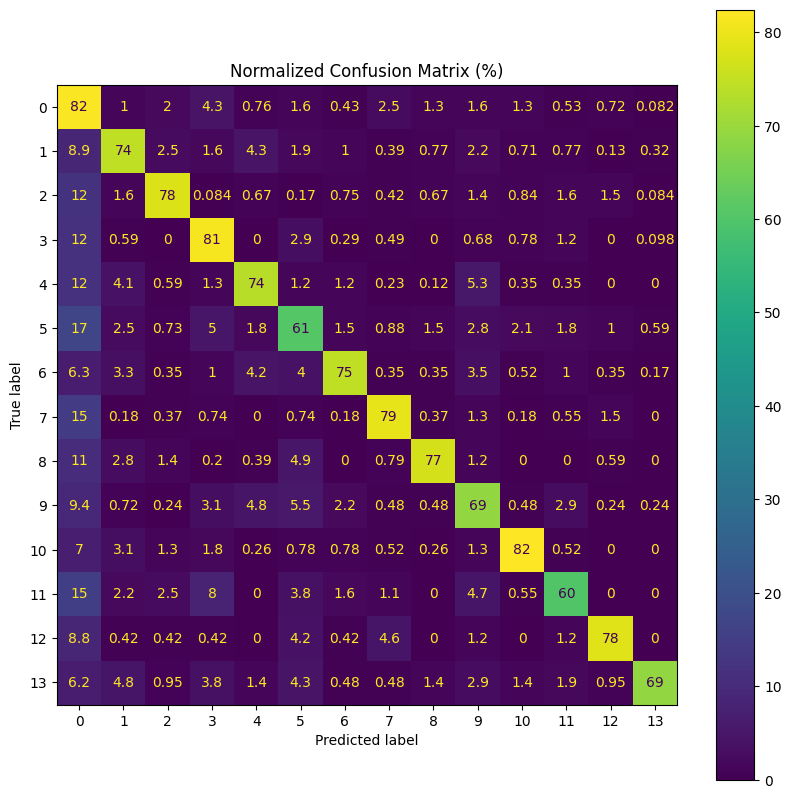

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Normalized Confusion Matrix (%)")
confusion_matrix = sklearn.metrics.confusion_matrix(y_test_idx, y_pred, normalize="true") * 100
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot(ax=ax)
plt.show()

## Show random result from validation set

In [27]:
idx = torch.randint(len(prediction_class), (1,)).item()
print(f"Input Sentence #{idx}")
print("".join(X_test[idx]))
print("---")
print(f"Label: {y_test[idx]}")
print(f"Predicted {prediction_class[idx]}")

Input Sentence #9655
จยย วิ่งบนทางเท้า
---
Label: ทางเท้า
Predicted ทางเท้า
